# Scoring Utils

##### Get Metrics from scores.txt files saved in verification run

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
res = '/media/absp/4E897AE46CE3ABFA/IMSV/results/results/imsv/speaker_verification_ecapa_big/scores.txt'

with open(res) as f:
    scores = [line.split(' ') for line in f.readlines()]
print("Number of verification pairs = {}".format(len(scores)))

# Collecting positive and negative scores
positive_scores = []
negative_scores = []

for (enrol_id, test_id, lab_pair, score) in scores:
    if int(lab_pair) == 1:
        positive_scores.append(float(score))
    else:
        negative_scores.append(float(score))

import torch
from tqdm.contrib import tqdm
from speechbrain.utils.metric_stats import EER, minDCF

Number of verification pairs = 150


In [10]:
# EER
eer, th = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
print("EER(%)={}".format(eer * 100))
print("Th = {0:.3f}".format(th))

EER(%)=0.0
Th = 8.411


In [12]:
# Min-DCF
min_dcf, th = minDCF(torch.tensor(positive_scores[:10000]), torch.tensor(negative_scores[:10000]))
print("minDCF={}".format(min_dcf * 100))
print("Th = {0:.3f}".format(th))

minDCF=0.0
Th = 8.411


### Ensembling Stuff

### Averaging

In [1]:
import glob
from tqdm.notebook import tqdm
import numpy as np
import copy

In [2]:
def ensemble(files, fname, facts = None):
    def extract_tups(file):
        with open(file) as f:
            tups = [[z.strip() for i, z in enumerate(x.split(' '))] for x in f.readlines()]
            scores = np.array([float(t[3]) for t in tups])
        return tups, scores
    def tup_to_txt(tup, file = fname):
        tup = [' '.join(t)+'\n' for t in tup]
        with open(file, 'w') as f:
            f.writelines(tup)
    s_all = None
    if facts is None:
        facts = [1/len(files) for _ in files]
    for i, f in enumerate(files):
        t, s = extract_tups(f)
        if s_all is not None:
            s_all += s*facts[i]
        else:
            s_all = s*facts[i]
    tf = []
    for i, ti in enumerate(t):
        tx = copy.deepcopy(ti)
        tx[-1] = str(s_all[i])
        tf.append(tx)
    tup_to_txt(tf)

In [3]:
globfs = "/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/*/scores.txt"
files = glob.glob(globfs)
ensemble(files, 'avgd.txt')

In [34]:
files = [f for f in files if 'ecapa' in f]
ensemble(files, 'avgd_ecapa_only.txt')

In [4]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt']
ensemble(files, 'avgd_ecapa_closed.txt')

In [7]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_vggvox/scores.txt','/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_vggvox_DA/scores.txt']
ensemble(files, 'avgd_closed.txt')

In [16]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_vggvox/scores.txt','/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_vggvox_DA/scores.txt']
ensemble(files, 'avgd_closed_DiffEns.txt', [0.37474135, 0.03572364, 0.23668878, 0.35284623])

In [20]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt']
ensemble(files, 'avgd_ecapa_closed_DiffEns.txt', [0.74896971, 0.25103029])

In [7]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big/scores.txt',
 '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt',
 '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained_pretrained/scores.txt',
 '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt',
 '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA_pretrained/scores.txt']
weights = np.array([5.1428, 3.0488, 3.3043, 2.7601, 2.8076])
weights = np.exp(-weights)
weights = weights / sum(weights)
ensemble(files, 'scores/weightedavgd_expacc.txt', weights)

In [8]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_big_trained/scores.txt',
 '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_test/speaker_verification_ecapa_DA/scores.txt']
weights = np.array([3.0488, 2.7601])
weights = np.exp(-weights)
weights = weights / sum(weights)
ensemble(files, 'scores/weightedavgd_expacc_closed.txt', weights)

### Differential Evolution

In [7]:
import warnings
warnings.filterwarnings('ignore')
import glob

import torch
# global optimization to find coefficients for weighted ensemble on blobs problem
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from numpy import mean
import numpy as np
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from scipy.optimize import differential_evolution
from speechbrain.utils.metric_stats import EER, minDCF

# make an ensemble prediction for multi-class classification
def ensemble_predictions(preds, weights):
    return sum([p*w for p, w in zip(preds, weights)])
    
# # evaluate a specific number of members in an ensemble
def evaluate_ensemble(preds, weights, lpf):
    scores = ensemble_predictions(preds, weights)
    # Collecting positive and negative scores
    positive_scores = []
    negative_scores = []
    for i, score in enumerate(scores):
        lab_pair = lpf[i]
        if int(lab_pair) == 1:
            positive_scores.append(score)
        else:
            negative_scores.append(score)
    eer, th = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    return 1-eer

# normalize a vector to have unit norm
def normalize(weights):
    result = norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

# loss function for optimization process, designed to be minimized
def loss_function(weights, preds, lpf):
    # normalize weights
    normalized = normalize(weights)
    # calculate error rate
    return 1.0 - evaluate_ensemble(preds, weights, lpf)

In [17]:
files = ['/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_verify/speaker_verification_ecapa_big_trained/scores.txt', '/media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_verify/speaker_verification_ecapa_DA/scores.txt']
n_members = len(files)
scores_all = []
for res in files:
    print("reading {}".format(res))
    with open(res) as f:
        scores = [float(line.split(' ')[-1]) for line in f.readlines()]
    scores_all.append(np.array(scores))
with open(res) as f:
    lpf = [int(line.split(' ')[-2]) for line in f.readlines()]

# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(scores_all, weights, lpf)
print('Equal Weights Score: %.3f' % score)

reading /media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_verify/speaker_verification_ecapa_big_trained/scores.txt
reading /media/absp/4E897AE46CE3ABFA/IMSV/results/imsv_verify/speaker_verification_ecapa_DA/scores.txt
Equal Weights Score: 0.980


In [18]:
# define bounds on each weight
bound_w = [(0.0, 1.0)  for _ in range(n_members)]
# arguments to the loss function
search_arg = (scores_all, lpf)
# global optimization of ensemble weights
result = differential_evolution(func = loss_function, bounds = bound_w, args = search_arg, maxiter=1000, tol=1e-7)
# get the chosen weights
weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)
# evaluate chosen weights
score = evaluate_ensemble(scores_all, weights, lpf)
print('Optimized Weights Score: %.3f' % score)

Optimized Weights: [0.74896971 0.25103029]
Optimized Weights Score: 0.995


#### FILTER PLOT

In [8]:
import torch
import math

In [9]:
n_mels = 80

In [10]:
def _to_mel(hz):
    return 2595 * math.log10(1 + hz / 700)

def _to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

In [12]:
f_min = 0
f_max = 8000

mel = torch.linspace(
    _to_mel(f_min), _to_mel(f_max), n_mels + 2
)
hz = _to_hz(mel)

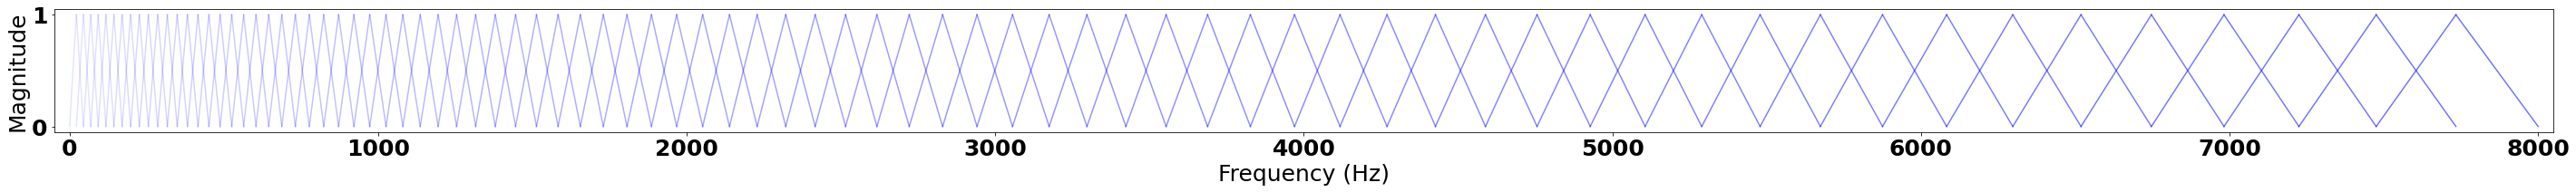

In [54]:
import matplotlib
import matplotlib.pyplot as plt
import numpy
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)


plt.rcParams["figure.figsize"] = [40, 3.50]
plt.rcParams["figure.autolayout"] = True
for i in range(1, len(hz)-1):
    fmin = hz[i-1]
    fmax = hz[i+1]
    f = hz[i]
    line = [[(fmin, 0), (f, 1)], [(f, 1), (fmax, 0)]]
    c = numpy.random.rand(3,)
    for [point1, point2] in line:
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        plt.plot(x_values, y_values, c='b', alpha=0.1+0.9*float(i)/(n_mels*2))
plt.xlim(-50, 8050)
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
# plt.yticks([]) 
plt.savefig('filter.pdf', bbox_inches='tight', pad_inches=0)

### New model

In [1]:
from speechbrain.lobes.models.transformer.SimpleTransformerSV import TransformerSV

torchvision is not available - cannot save figures


In [2]:
import torch
src = torch.rand([8, 120, 256])
net = TransformerSV(d_model=256, output_size=257)
out = net(src)
out.shape

torch.Size([8, 1, 257])

In [1]:
from speechbrain.lobes.models.ECAPA_TDNN import ECAPA_TDNN

torchvision is not available - cannot save figures


In [5]:
import torch
src = torch.rand([8, 120, 80])
net = ECAPA_TDNN(80)
out = net(src)
out.shape

torch.Size([8, 1, 192])